# Prudential life insurance      
데이터셋 - Kaggle(2015)    
형태 - 파일데이터(csv)           
다운로드 - https://www.kaggle.com/c/prudential-life-insurance-assessment 

# 1. Introduction

 프루덴셜생명보험의 보험계약자 데이터를 활용하여 보험계약자의 위험등급을 예측하고자 한다.      
 약 80,000 명의 보험계약자와 127 개의 변수를 가진 데이터로, 대부분의 변수는 마스킹되고 정규화 되어 있다.      
 종속변수 'Response' 는 8개의 등급으로 분류되어 있다.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.rc('font', family='NanumBarunGothic') 
plt.rcParams['figure.figsize'] = (10, 7)

pd.set_option('display.float_format', lambda x: '%.2f' % x)

%matplotlib inline 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
filename = '/content/sample_data/train.csv'
filename1 = '/content/sample_data/test.csv'
orgin = pd.read_csv(filename)
orgin1 = pd.read_csv(filename1)
orgin.shape, orgin1.shape 

((59381, 128), (19765, 127))

In [4]:
train = orgin.copy()
test = orgin1.copy()

In [5]:
train.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,...,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.08,2,1,1,0.64,0.58,0.15,0.32,0.03,12,1,0.00,3,nan,1,2,6,3,1,2,1,1,1,3,1,0.00,1,1,2,2,nan,0.60,nan,0.53,4.00,112,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.08,2,3,1,0.06,0.60,0.13,0.27,0.00,1,3,0.00,2,0.00,1,2,6,3,1,2,1,2,1,3,1,0.00,1,3,2,2,0.19,nan,0.08,nan,5.00,412,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.08,2,3,1,0.03,0.75,0.29,0.43,0.03,9,1,0.00,2,0.03,1,2,8,3,1,1,1,2,1,1,3,nan,3,2,3,3,0.30,nan,0.23,nan,10.00,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.49,2,3,1,0.16,0.67,0.21,0.35,0.04,9,1,0.00,3,0.20,2,2,8,3,1,2,1,2,1,1,3,nan,3,2,3,3,0.42,nan,0.35,nan,0.00,350,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.23,2,3,1,0.42,0.65,0.23,0.42,0.03,9,1,0.00,2,0.05,1,2,6,3,1,2,1,2,1,1,3,nan,3,2,3,2,0.46,nan,0.41,nan,nan,162,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8


#2. Data
 데이터는 Train : Test = 3 : 1 비율로 분리되고 무작위 샘플링으로 이루어진다. Train data는 59,381명, 126개 변수로 구성된 transactional data(low level)이고 , Test data는 19,766명, 126개 변수로 구성된다. Normalized 변수의 범주는 다음과 같다. 
  * **ID** : 청약자의 고유 식별정보 
  * **Product Information** 보험상품 : Info_1 ~ Info_7 
  * **Insurance Age** 보험나이 
  * **Height** 키 
  * **Weight** 몸무게 
  * **BMI** 체질량 지수 
  * **Employment Information** 고용정보 : Info_1 ~ Info_6 
  * **Insured Information** 계약자정보 : Info_1 ~ Info_7
  * **Insurance History** 보험내역 : Info_1 ~ Info_9
  * **Family History** 가족력 : Info_1 ~ Info_5
  * **Medical History** 기왕력 : Info_1 ~ Info_41
  * **Medical Keyword** 메디컬 키워드 : Info_1 ~ Info_48 

각 범주에는 class 별 여러 변수가 포함되어 있다. 

   
  

In [6]:
df = pd.DataFrame(["Product Information",
"Insurance Age",
"Height",
"Weight", 
"BMI",
"Employment Information",
"Insured Information",
"Insurance History",
"Family History",
"Medical History",
"Medical Keyword"], columns = ['Variable_type'])

df['Continous'] = [1,1,1,1,1,3,0,1,4,0,0]
df['Categorical'] = [6,0,0,0,0,3,7,8,1,36,0]
df['Descrete'] = [0,0,0,0,0,0,0,0,0,5,48]
df['Total'] = df.iloc[:, 1:4].sum(axis=1)
df

,Variable_type,Continous,Categorical,Descrete,Total
0,Product Information,1,6,0,7
1,Insurance Age,1,0,0,1
2,Height,1,0,0,1
3,Weight,1,0,0,1
4,BMI,1,0,0,1
5,Employment Information,3,3,0,6
6,Insured Information,0,7,0,7
7,Insurance History,1,8,0,9
8,Family History,4,1,0,5
9,Medical History,0,36,5,41


#3. Analysing features


## Step1 : Remove Outliers based on IQR range

In [7]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out


dev=remove_outlier(train,'BMI')
dev=remove_outlier(dev,'Wt')
dev=remove_outlier(dev,'Ht')

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


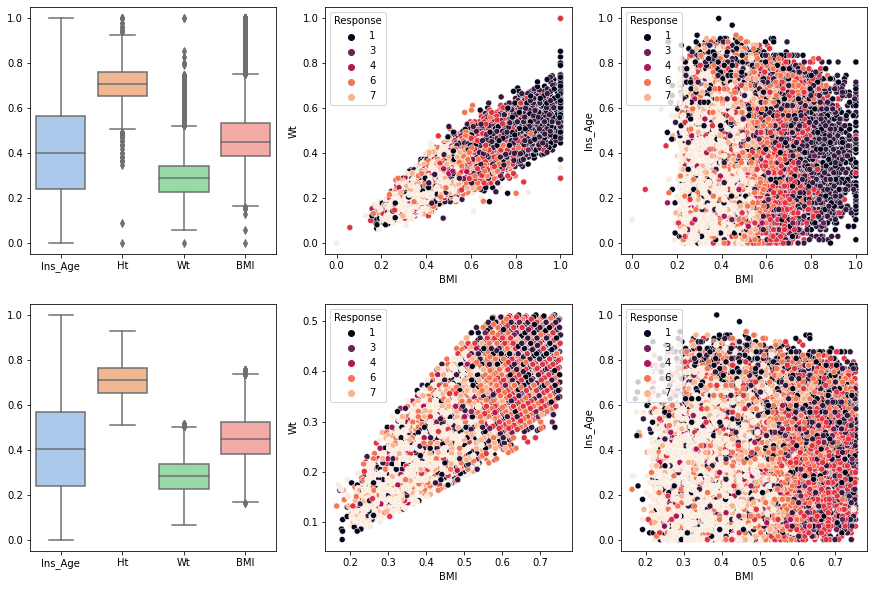

In [8]:
f, axes = plt.subplots(2, 3, figsize=(15,10))
misc_cols=["Ins_Age","Ht","Wt","BMI"]
sns.boxplot(data=train[misc_cols],palette ='pastel', ax=axes[0,0])
sns.scatterplot(data=train,x='BMI',y='Wt',hue='Response',alpha=1,palette="rocket", ax=axes[0,1])
sns.scatterplot(data=train,x='BMI',y='Ins_Age',hue='Response',alpha=1,palette="rocket", ax=axes[0,2])
sns.boxplot(data=dev[misc_cols], palette ='pastel', ax=axes[1,0])
sns.scatterplot(data=dev,x='BMI',y='Wt',hue='Response',alpha=1, palette="rocket", ax=axes[1,1])
sns.scatterplot(data=dev,x='BMI',y='Ins_Age',hue='Response',alpha=1, palette="rocket", ax=axes[1,2])
                

In [54]:
train['BMI'].describe()
out = train.copy()

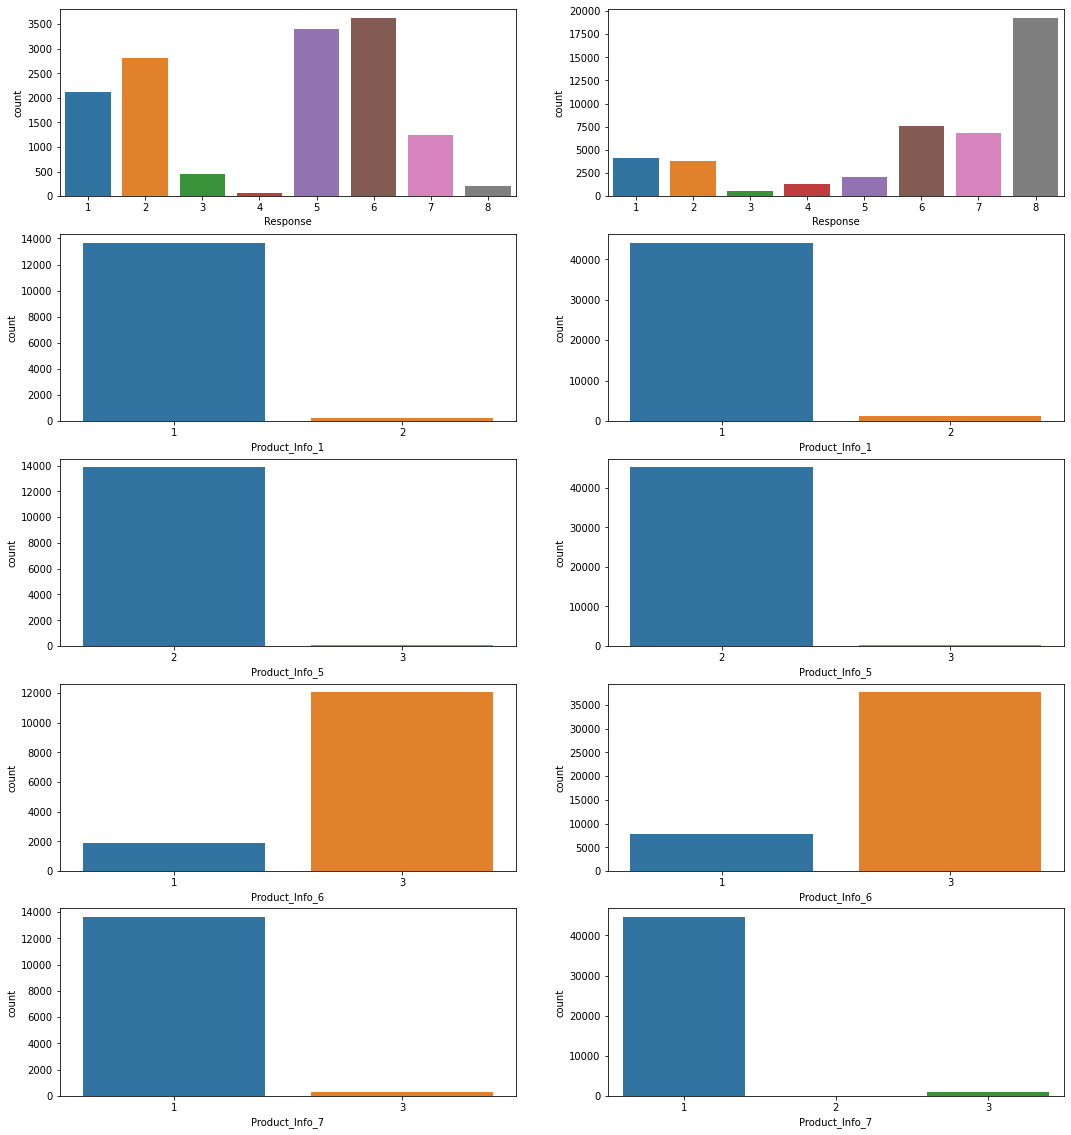

In [62]:
f,ax=plt.subplots(5,2,figsize=(18,20))
outBMI = out.loc[out['BMI'] >= 0.54, :]
inBMI = out.loc[out['BMI'] < 0.54, :]
#outBMI['Response'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
sns.countplot('Response',data=outBMI,ax=ax[0,0])
sns.countplot('Response',data=inBMI,ax=ax[0,1])

#inBMI['Response'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1],shadow=True)
sns.countplot('Product_Info_1',data=outBMI,ax=ax[1,0])
sns.countplot('Product_Info_1',data=inBMI,ax=ax[1,1])
sns.countplot('Product_Info_5',data=outBMI,ax=ax[2,0])
sns.countplot('Product_Info_5',data=inBMI,ax=ax[2,1])
sns.countplot('Product_Info_6',data=outBMI,ax=ax[3,0])
sns.countplot('Product_Info_6',data=inBMI,ax=ax[3,1])
sns.countplot('Product_Info_7',data=outBMI,ax=ax[4,0])
sns.countplot('Product_Info_7',data=inBMI,ax=ax[4,1])

##Step 2: Remove columns with high missing value percentage

In [9]:
#dropping the columns with more than 30% missing values
missing_val_count_by_column = (dev.isnull().sum()/len(dev))
print(missing_val_count_by_column[missing_val_count_by_column > 0.3])
cols_to_drop=missing_val_count_by_column[missing_val_count_by_column > 0.3].index.values

# Make copy to avoid changing original data 
out_enc_X_train = dev.drop(labels=cols_to_drop,axis=1).copy()


Insurance_History_5   0.43
Family_Hist_2         0.48
Family_Hist_3         0.58
Family_Hist_4         0.32
Family_Hist_5         0.71
Medical_History_10    0.99
Medical_History_15    0.75
Medical_History_24    0.94
Medical_History_32    0.98
dtype: float64


In [10]:
#identify all cols with medical keywords
medical_keyword_cols=[col for col in out_enc_X_train.columns if str(col).startswith("Medical_Keyword")]

#identify all cols with medical keywords
medical_cols=[col for col in out_enc_X_train.columns if str(col).startswith("Medical_History")]

out_enc_X_train['Total_MedKwrds']=out_enc_X_train[medical_keyword_cols].sum(axis=1)
out_enc_X_train['Total_MedHist']=out_enc_X_train[medical_cols].sum(axis=1)

In [11]:
out_enc_X_train

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,...,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response,Total_MedKwrds,Total_MedHist
0,2,1,D3,10,0.08,2,1,1,0.64,0.58,0.15,0.32,0.03,12,1,0.00,3,nan,1,2,6,3,1,2,1,1,1,3,1,1,1,2,2,4.00,112,2,1,1,3,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,190.00
1,5,1,A1,26,0.08,2,3,1,0.06,0.60,0.13,0.27,0.00,1,3,0.00,2,0.00,1,2,6,3,1,2,1,2,1,3,1,1,3,2,2,5.00,412,2,1,1,3,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,487.00
2,6,1,E1,26,0.08,2,3,1,0.03,0.75,0.29,0.43,0.03,9,1,0.00,2,0.03,1,2,8,3,1,1,1,2,1,1,3,3,2,3,3,10.00,3,2,2,1,3,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,88.00
3,7,1,D4,10,0.49,2,3,1,0.16,0.67,0.21,0.35,0.04,9,1,0.00,3,0.20,2,2,8,3,1,2,1,2,1,1,3,3,2,3,3,0.00,350,2,2,1,3,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,1,425.00
4,8,1,D2,26,0.23,2,3,1,0.42,0.65,0.23,0.42,0.03,9,1,0.00,2,0.05,1,2,6,3,1,2,1,2,1,1,3,3,2,3,2,nan,162,2,2,1,3,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,237.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59376,79142,1,D1,10,0.23,2,3,1,0.07,0.71,0.32,0.52,0.02,1,3,0.00,3,0.03,1,2,8,3,1,2,1,2,1,1,3,3,2,3,3,0.00,261,2,1,1,3,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,336.00
59377,79143,1,D3,26,0.23,2,3,1,0.43,0.80,0.40,0.55,0.10,9,1,0.00,2,0.35,1,2,3,3,1,1,1,2,1,3,2,1,3,2,3,24.00,491,2,2,1,3,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,590.00
59378,79144,1,E1,26,0.08,2,3,1,0.10,0.75,0.25,0.36,0.04,9,1,0.00,2,nan,1,2,6,3,1,1,1,2,1,1,3,3,2,3,3,nan,162,2,2,1,3,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,8,1,235.00
59379,79145,1,D2,10,0.23,2,3,1,0.51,0.69,0.28,0.46,0.04,9,1,nan,3,nan,1,2,3,3,1,2,1,2,1,1,3,3,2,3,2,0.00,16,2,1,1,3,2,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,8,2,87.00


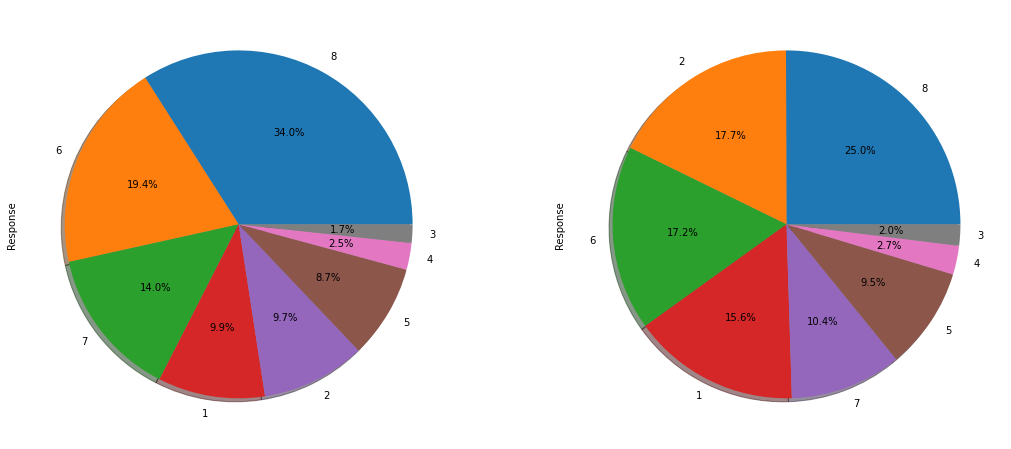

In [45]:
f,ax=plt.subplots(1,2,figsize=(18,8))
exam = out_enc_X_train.copy()

med120 = exam.loc[exam['Medical_Keyword_12'] == 0, :]
med120['Response'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
med121 = exam.loc[exam['Medical_Keyword_12'] == 1, :]
med121['Response'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1],shadow=True)

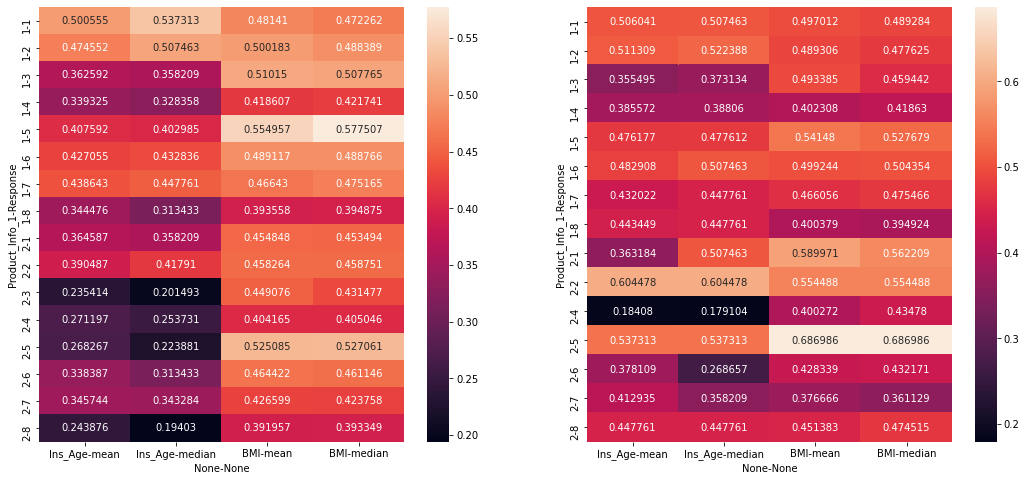

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

In [52]:
f,ax=plt.subplots(1,2,figsize=(18,8))
A = med120.groupby(['Product_Info_1','Response'])['Ins_Age','BMI'].agg(["mean","median"])
plt.figure(figsize=(12,12))
sns.heatmap(A,annot=True,fmt='g',ax=ax[0])
B = med121.groupby(['Product_Info_1','Response'])['Ins_Age','BMI'].agg(["mean","median"])
plt.figure(figsize=(12,12))
sns.heatmap(B,annot=True,fmt='g',ax=ax[1])

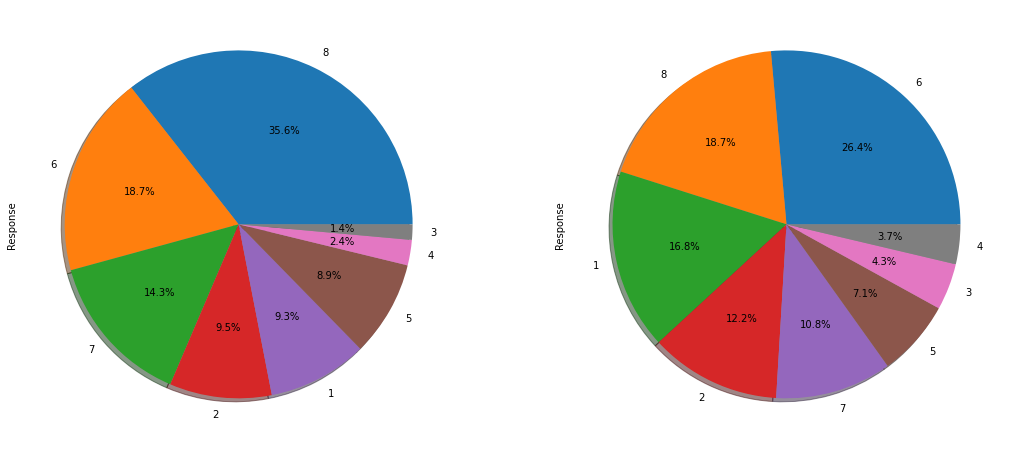

In [39]:
f,ax=plt.subplots(1,2,figsize=(18,8))
exam = out_enc_X_train.copy()

med230 = exam.loc[exam['Medical_Keyword_23'] == 0, ['Medical_Keyword_23','Response']]
med230['Response'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
med231 = exam.loc[exam['Medical_Keyword_23'] == 1, ['Medical_Keyword_23','Response']]
med231['Response'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1],shadow=True)

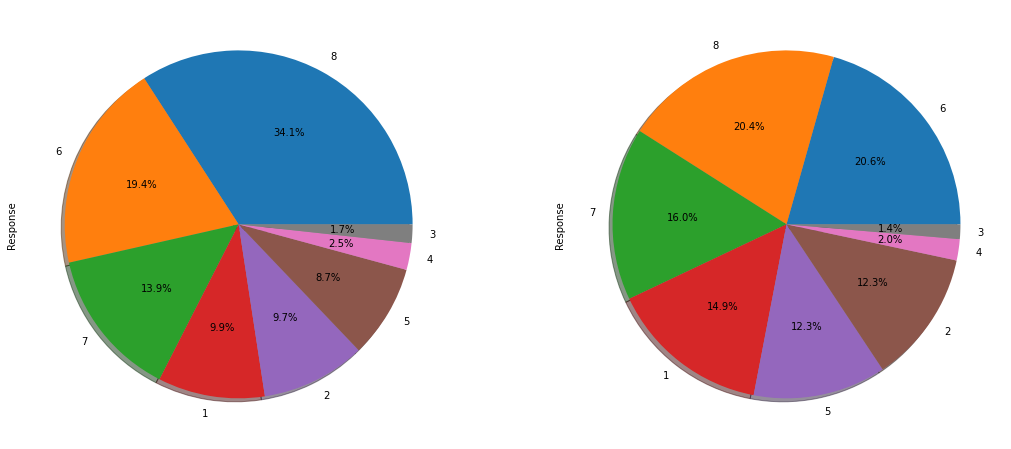

In [40]:
f,ax=plt.subplots(1,2,figsize=(18,8))
exam = out_enc_X_train.copy()

med040 = exam.loc[exam['Medical_Keyword_4'] == 0, ['Medical_Keyword_4','Response']]
med040['Response'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
med041 = exam.loc[exam['Medical_Keyword_4'] == 1, ['Medical_Keyword_4','Response']]
med041['Response'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1],shadow=True)

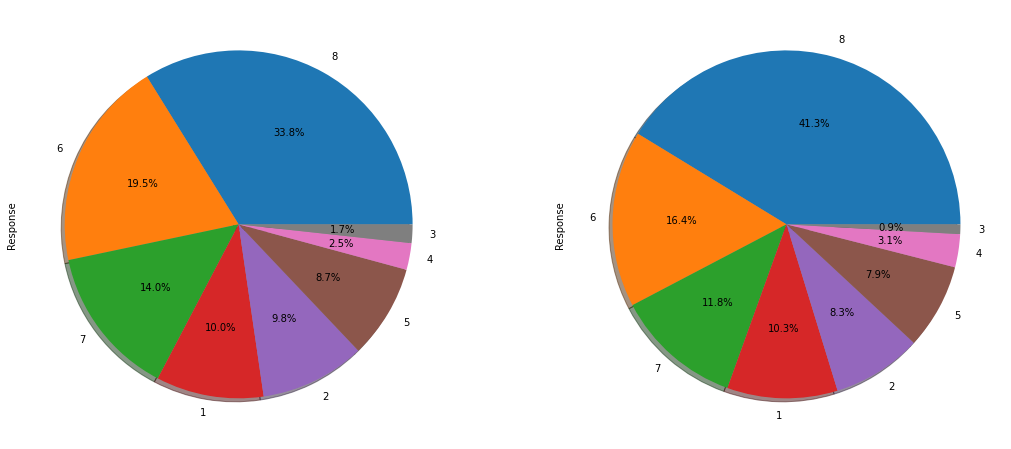

In [42]:
f,ax=plt.subplots(1,2,figsize=(18,8))
exam = out_enc_X_train.copy()

med390 = exam.loc[exam['Medical_Keyword_39'] == 0, ['Medical_Keyword_39','Response']]
med390['Response'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
med391 = exam.loc[exam['Medical_Keyword_39'] == 1, ['Medical_Keyword_39','Response']]
med391['Response'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1],shadow=True)

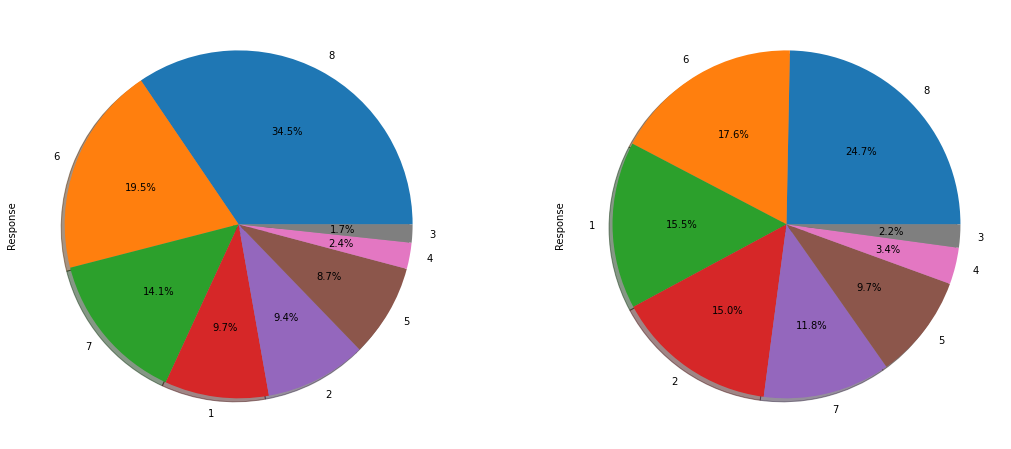

In [43]:
f,ax=plt.subplots(1,2,figsize=(18,8))
exam = out_enc_X_train.copy()

med400 = exam.loc[exam['Medical_Keyword_40'] == 0, ['Medical_Keyword_40','Response']]
med400['Response'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
med401 = exam.loc[exam['Medical_Keyword_40'] == 1, ['Medical_Keyword_40','Response']]
med401['Response'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1],shadow=True)